**Todos**
- [ ] Revisit separatrix crossing calculation

To-run list:
- [x] $\mu_p=5e-5$ random capture grid
- [x] $\mu_p=5e-5$ random capture grid w/ $\beta_p=0$
    - NEED TO FIX: $\varpi_0$ not randomly selected
- [x] $\mu_p=5e-5$ random capture grid w/ no secular effects

Wanting to plot $\phi$ over time next

- Right now, the random grid has $\varpi_0=0$ and a random $\theta_{p,0}$.. May need to check this?

In [1]:
%%capture
%run EOMs.ipynb

# Right hand side for numerical integrations

In [4]:
npy.random.randint(0,10000,4)

array([7926, 5949, 2742, 6812])

In [5]:
Eq(np,exp(-t/tm))

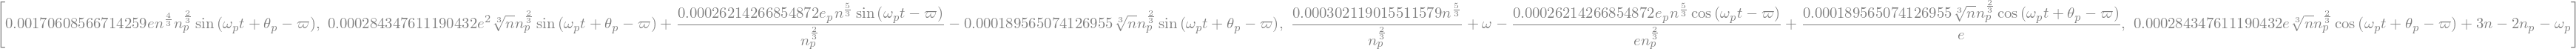

In [6]:
TMVAL = 2 * npy.pi * 1e6
convs = {}
convs = {ap: n ** Rational(2, 3) / np ** Rational(2, 3) * a, th: thp + omp * t - pom}
params = {}
params = {
    j: 2,
    mup: 1e-4,
    bp: 0,#1.5455341716765871,
    b: 1.8956507412695471,
    b1_3_2: 12.08476062046314,
    b2_3_2: 10.485706741948807,
}

alpha0val = (params[j] / (params[j] + 1)) ** (2.0 / 3)
# params[omp] = 0
# params[om] = params[omp] * alpha0val**3.5


funs = [
    iterfun.subs(convs).subs(params)
    for iterfun in [ndot, edot + edsec, pomdot + pomdsec, thpdot]
]
funs

In [7]:
xp = [n, e, pom, thp, np, t]

In [8]:
lambdastr(xp, funs).replace("math", "npy")

'lambda n,e,varpi,theta_p,n_p,t: ([0.00170608566714259*e*n**(4/3)*n_p**(2/3)*npy.sin(omega_p*t + theta_p - varpi), 0.000284347611190432*e**2*n**(1/3)*n_p**(2/3)*npy.sin(omega_p*t + theta_p - varpi) + 0.00026214266854872*e_p*n**(5/3)*npy.sin(omega_p*t - varpi)/n_p**(2/3) - 0.000189565074126955*n**(1/3)*n_p**(2/3)*npy.sin(omega_p*t + theta_p - varpi), 0.000302119015511579*n**(5/3)/n_p**(2/3) + omega - 0.00026214266854872*e_p*n**(5/3)*npy.cos(omega_p*t - varpi)/(e*n_p**(2/3)) + 0.000189565074126955*n**(1/3)*n_p**(2/3)*npy.cos(omega_p*t + theta_p - varpi)/e, 0.000284347611190432*e*n**(1/3)*n_p**(2/3)*npy.cos(omega_p*t + theta_p - varpi) + 3*n - 2*n_p - omega_p])'

In [ ]:
funcl = lambdify(xp, funs)


def func(t, x0):
    npval = npy.exp(-t/TMVAL)
    #npval = 1 - t / TMVAL
    return funcl(*x0, npval, t)

In [ ]:
#teval = npy.linspace(0, 2 * npy.pi * 7.5e5, 10000)
#sol = sp.integrate.solve_ivp(
#    func,
#    [teval[0], teval[-1]],
#    [1/1.55, 0.001, 1, 2],
#    t_eval=teval,
#    rtol=1e-9,
#    #atol=1e-9,
#    method="DOP853",
#)

In [ ]:
#fig, ax = plt.subplots()
#ax.plot(sol.t,sol.y[0,:])
#ax.plot(sol.t,sol.y[0,:]/npy.exp(-sol.t/TMVAL))
#ax.plot(sol.t,sol.y[1,:])
#ax.scatter(sol.t,sol.y[2,:]%(2*npy.pi))
#ax.scatter(sol.t,sol.y[3,:]%(2*npy.pi))
#ax.scatter(sol.t,(sol.y[3,:]+params[omp]*sol.t-sol.y[2,:])%(2*npy.pi))

# Single grid and chaos grid

In [ ]:
TMVAL = 2*npy.pi*1e6
with open("results_mup5e-5_tm2pi1e6_n1.55_omalpha0val3.5_chaos_hidens.pkl", "rb") as f:
    jobs, results = pickle.load(f)

In [ ]:
outcomes = []
for ind, result in enumerate(results):
    if ind % 100 == 0:
        outcomes += [0]
    params = jobs[ind]
    nRatio = results[ind].y[0,-1]/npy.exp(-results[ind].t[-1]/TMVAL)
    if len(result.t_events[0]) == 0:
        outcomes[-1] = outcomes[-1] + 1
outcomes = [outcome/100 for outcome in outcomes]

In [ ]:
joblist = [jobs[100*i] for i in range(len(outcomes))]

In [ ]:
#joblist = joblist + [jobs[100*i] for i in range(len(outcomes_extended))]
eplist = [job[1] for job in joblist]
Domextlist = [job[2]-job[3] for job in joblist]
indlist = [job[0] for job in joblist]
Domextlist

In [ ]:
with open("results_mup5e-5_tm2pi1e6_n1.55_omalpha0val3.5.pkl", "rb") as f:
    jobs, results = pickle.load(f)

In [ ]:
212, 398, 584,
198, 384, 570, 
98, 191, 284, 377, 470, 563,
112, 205, 298, 391, 484, 577
119,105
305,291
491,477

In [ ]:
with open("singles_mup5e-5_tm2pi1e6_n1.55_omalpha0val3.5.pkl", "rb") as f:
    jobssingle, _ = pickle.load(f)
epsingle = [j[1] for j in jobssingle]
Dpomsingle = [j[2]-j[3] for j in jobssingle]

In [ ]:
jobssingle

In [ ]:
fig = plt.figure(figsize=(6.5,4.5)) 
gs = fig.add_gridspec(2, 2,height_ratios=[10,1]) 
ax1 = fig.add_subplot(gs[0, 0]) 
ax2 = fig.add_subplot(gs[1, 0]) 
ax3 = fig.add_subplot(gs[0, 1])

leg1 = False
leg2 = False
for ind, result in enumerate(results):
    params = jobs[ind]
    nRatio = results[ind].y[0,-1]/npy.exp(-results[ind].t[-1]/TMVAL)
    if nRatio > 0.8:
        if not leg1:
            leg1 = True
            ax1.scatter(params[1],params[2]-params[3],c="r",label="Escape")
        else:
            ax1.scatter(params[1],params[2]-params[3],c="r")
            #ax1.text(params[1],params[2]-params[3],params[0])
    else:
        if not leg2:
            leg2 = True
            ax1.scatter(params[1],params[2]-params[3],c="k",label="Capture")
        else:
            ax1.scatter(params[1],params[2]-params[3],c="k")
            #ax1.text(params[1],params[2]-params[3],params[0])
    #ax1.text(params[1],params[2]-params[3],f"{ind}")
#ax1.scatter(epsingle,Dpomsingle,c="c",marker="x")
ax1.set_yscale("log")#,linthresh=5e-6,linscale=0.05)
ax1.set_xticks([])
ax1.set_ylabel(r"$\Delta\omega_{\rm ext}/n_{\rm p,0}$")
ax1.axhline(y=DPOM_GPS,c="c",ls="--",lw=3)
ax1.legend(bbox_to_anchor=[0.3,1])

for ind, result in enumerate(results):
    params = jobs[ind]
    nRatio = results[ind].y[0,-1]/npy.exp(-results[ind].t[-1]/TMVAL)
    if params[2]-params[3] == 0:
        if nRatio > 0.8:
            ax2.scatter(params[1],params[2]-params[3],c="r")
        else:
            ax2.scatter(params[1],params[2]-params[3],c="k")
        #ax2.text(params[1],params[2]-params[3],f"{ind}")
ax2.set_yticks([0])
ax2.set_xlabel(r"$e_{\rm p}$")
#ax2.scatter(epsingle[2],Dpomsingle[2],c="c",marker="x")

#x = npy.linspace(0.01,0.1,1000)
#ax1.plot(x,5e-5**(4./3)/x**2/12)
#ax1.axvline(x=(5e-5)**(1./3))
#ax1.axhline(y=5e-5**(2./3))

cs = ax3.scatter(eplist, Domextlist,c=outcomes)
cb_ax = fig.add_axes([0.55,0.86,.39,.03])
fig.colorbar(cs,orientation='horizontal',cax=cb_ax)
cb_ax.xaxis.set_ticks_position('top')
cb_ax.set_title(r"Capture Probability")
for i, outcome in enumerate(outcomes):
    ax3.text(eplist[i]+0.002, Domextlist[i]*1.05,f"{outcome}",size=5)
    ax3.text(eplist[i]+0.002, Domextlist[i]*0.9,f"{indlist[i]}",size=5)

ax3.set_xlim(ax2.get_xlim())

ax3.set_yscale("log")
ax3.set_ylim(ax1.get_ylim())
ax3.set_yticks([])
ax3.set_yticks([],minor=True)
ax3.set_xlabel(r"$e_{\rm p}$")

fig.tight_layout()
fig.subplots_adjust(wspace=0,hspace=0)

In [ ]:
291, 298

In [ ]:
jobs[279]

In [ ]:
fig.savefig("/Users/jtlaune/Desktop/grid.svg")

# Random grids

- atol & rtol = 1e-9
- $T_m = 2\pi\times10^6$
- $\mu_p=5\times10^{-5}$

Start $n_p/n = 1.55$ and decrease $n_p$ to resonance crossing. 

"Escape" is the condition $n/n_p=0.8$ in the integration and exits the integration if crossed. 

Capture = no event.

Currently re-running all random grids. Realized had $\mu_p=1e-4$, and had secular coefficients wrong. $\mu_p$ has been fixed.

Currently, the "standard" and "no sec" grids has a randomly selected $\varpi_0$, but the "no bp" runs do not. Need to change the latter to be in line with the former.

## Standard

In [105]:
mupint = 5e-5
mupstr = f"{mupint:0.0e}".replace('e-0', 'e-').replace('e+0', 'e')
muplatex = f"{mupint:0.0e}".replace('e-0', 'e-').replace('e+0', 'e').replace("e", r" \times 10^{") + "}"
print(mupstr)
print(muplatex)
TMVAL = 2*npy.pi*1e6
with open(f"results_mup{mupstr}_tm2pi1e6_n1.55_omalpha0val3.5_random10000.pkl", "rb") as f:
    jobs, results = pickle.load(f)

5e-5
5 \times 10^{-5}


In [108]:
N_jobs = len(results)
eps = npy.zeros(N_jobs)
omps = npy.zeros(N_jobs)
oms = npy.zeros(N_jobs)
outcomes = npy.zeros(N_jobs)
X = npy.zeros((N_jobs,2))

for i in range(N_jobs):
    eps[i] = jobs[i][1]
    omps[i] = jobs[i][2]
    oms[i] = jobs[i][3]
    X[i,0]= jobs[i][1]
    X[i,1]= npy.log10(jobs[i][2])
    if len(results[i].t_events[0]) > 0:
        outcomes[i] = 1
print(npy.sum(outcomes))

7132.0


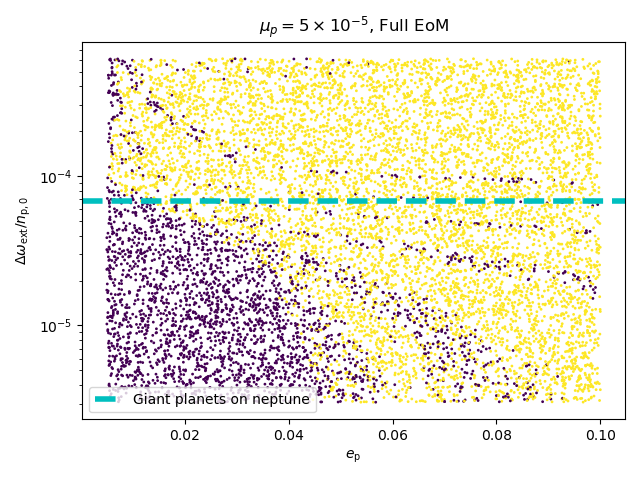

In [112]:
fig, ax = plt.subplots()
#for i in range(N_jobs):
#    ax.text(eps[i],omps[i]-oms[i],f"{i}")
ax.scatter(eps,omps-oms,c=outcomes,s=1)
ax.set_yscale("log")
ax.set_ylabel(r"$\Delta\omega_{\rm ext}/n_{\rm p,0}$")
ax.set_xlabel(r"$e_{\rm p}$")
ax.set_title(r"$\mu_p="+muplatex+"$, Full EoM")
ax.axhline(y=DPOM_GPS,c="c",ls="--",lw=4,label="Giant planets on neptune")
plt.tight_layout()
fig.savefig(f"{mupstr} Capture Full EoM.png",dpi=300,bbox_inches="tight")
ax.legend()

## No Bp and No Sec investigation

- These were ran by setting beta_p = 0 for nobp, and b1_3_2=b2_3_2=0 for no secular

### No bp

In [114]:
TMVAL = 2*npy.pi*1e6
with open(f"results_mup{mupstr}_tm2pi1e6_n1.55_omalpha0val3.5_random10000_nobp.pkl", "rb") as f:
    jobs, results = pickle.load(f)

N_jobs = len(results)
eps = npy.zeros(N_jobs)
omps = npy.zeros(N_jobs)
oms = npy.zeros(N_jobs)
outcomes = npy.zeros(N_jobs)
X = npy.zeros((N_jobs,2))

for i in range(N_jobs):
    eps[i] = jobs[i][1]
    omps[i] = jobs[i][2]
    oms[i] = jobs[i][3]
    X[i,0]= jobs[i][1]
    X[i,1]= npy.log10(jobs[i][2])
    if len(results[i].t_events[0]) > 0:
        outcomes[i] = 1
print(npy.sum(outcomes))

5735.0


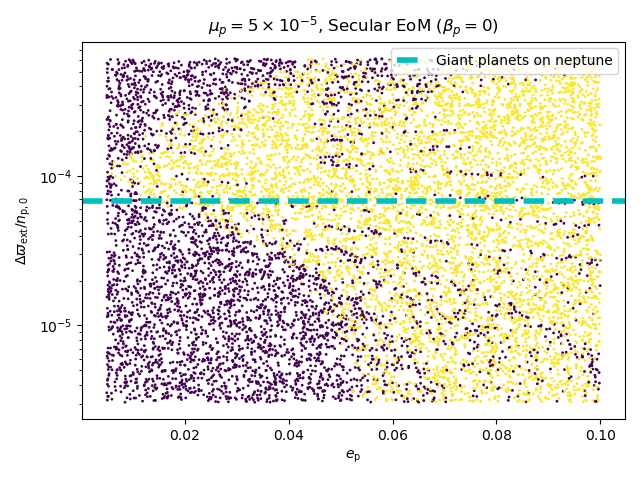

In [118]:
fig, ax = plt.subplots()
ax.scatter(eps,omps-oms,c=outcomes,s=1)
ax.set_yscale("log")
ax.set_ylabel(r"$\Delta\varpi_{\rm ext}/n_{\rm p,0}$")
ax.set_xlabel(r"$e_{\rm p}$")
ax.set_title(r"$\mu_p="+muplatex+"$, Secular EoM ($\\beta_p=0$)")
ax.axhline(y=DPOM_GPS,c="c",ls="--",lw=4,label="Giant planets on neptune")
ax.legend()
plt.tight_layout()
fig.savefig(f"{mupstr} Capture Secular EoM.png",dpi=300,bbox_inches="tight")

### No sec

In [ ]:
TMVAL = 2*npy.pi*1e6
with open("results_mup1e-4_tm2pi1e6_n1.55_omalpha0val3.5_random10000_nosec.pkl", "rb") as f:
    jobs, results = pickle.load(f)

N_jobs = len(results)
eps = npy.zeros(N_jobs)
omps = npy.zeros(N_jobs)
oms = npy.zeros(N_jobs)
outcomes = npy.zeros(N_jobs)
X = npy.zeros((N_jobs,2))

for i in range(N_jobs):
    eps[i] = jobs[i][1]
    omps[i] = jobs[i][2]
    oms[i] = jobs[i][3]
    X[i,0]= jobs[i][1]
    X[i,1]= npy.log10(jobs[i][2])
    if len(results[i].t_events[0]) > 0:
        outcomes[i] = 1
print(npy.sum(outcomes))

7697.0


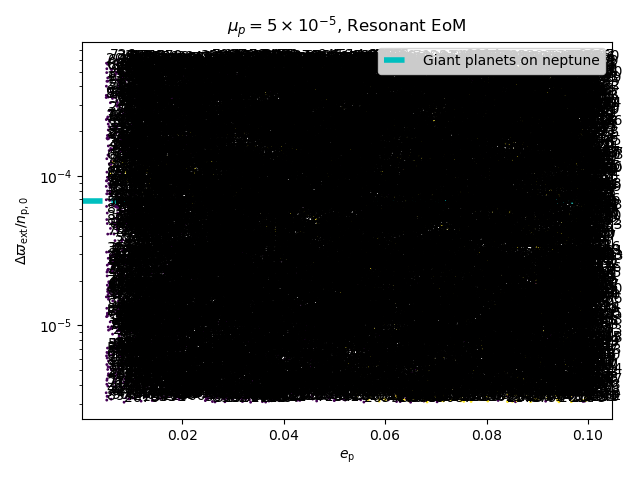

In [119]:
fig, ax = plt.subplots()
ax.scatter(eps,omps-oms,c=outcomes,s=1)
for i in range(N_jobs):
    ax.text(eps[i],omps[i]-oms[i],f"{i}")
ax.set_yscale("log")
ax.set_ylabel(r"$\Delta\varpi_{\rm ext}/n_{\rm p,0}$")
ax.set_xlabel(r"$e_{\rm p}$")
ax.set_title(r"$\mu_p="+muplatex+"$, Resonant EoM")
ax.axhline(y=DPOM_GPS,c="c",ls="--",lw=4,label="Giant planets on neptune")
ax.legend()
plt.tight_layout()
fig.savefig(f"{mupstr} Capture Resonant EoM.png",dpi=300,bbox_inches="tight")

# Individual Runs

## Plotting function

In [66]:
def plot(results, jobs, ind, fig, axes, color, t1, t2, mupint):
    t_ind1 = 0
    t_ind2 = -1
    t_ind1 = npy.where(results[ind].t >= t1)[0][0]
    t_ind2 = npy.where(results[ind].t >= t2)[0][0]

    jint = 2
    tint = results[ind].t[t_ind1:t_ind2]
    nint = results[ind].y[0, t_ind1:t_ind2]
    npint = npy.exp(-results[ind].t[t_ind1:t_ind2] / TMVAL)
    apint = npint**(-2./3)
    eint = results[ind].y[1, t_ind1:t_ind2]
    pomint = results[ind].y[2, t_ind1:t_ind2]
    thpint = results[ind].y[3, t_ind1:t_ind2]
    alphaint = (nint / npint) ** (2.0 / 3)
    bint = 1.8956507412695471
    mupint = 5e-5
    ompint = jobs[ind][2]
    omint = jobs[ind][3]
    aint = nint**(-2./3)
    ncint = (jint*npint+omint)/(jint+1)
    acint = ncint**(-2./3)

    print(jobs[ind])
    ax = axes[0]
    ax.set_ylabel(r"$n/n_{\rm p}$")
    ax.scatter(
        tint,
        nint / npint,
        #aint,
        0.1,
        c=color,
    )

    ax = axes[1]
    ax.set_ylabel(r"$\theta$")
    ax.scatter(
        tint,
        (thpint + ompint * tint - pomint) % (2 * npy.pi),
        0.1,
        c=color,
    )

    ax = axes[2]
    ax.set_ylabel(r"$\theta_{\rm p}$")
    ax.scatter(
        tint,
        thpint % (2 * npy.pi),
        0.1,
        c=color,
    )

    ax = axes[3]
    ax.set_ylabel(r"$\varpi_{\rm p}-\varpi$")
    ax.scatter(
        tint,
        (ompint * tint - pomint) % (2 * npy.pi),
        0.1,
        c=color,
    )

    ax = axes[4]
    ax.set_ylabel(r"$e$")
    ax.scatter(
        tint,
        eint,
        0.1,
        c=color,
    )

    ksep = -(3*(2+1)*apint*bint/(2**2*acint))**(1./3)*mupint**(2./3)
    kint = (aint-acint)/acint - (jint+1)*eint**2

    ax = axes[5]
    ax.set_ylabel(r"$k/k_{\rm sep}$")
    ax.scatter(
        tint,
        kint/ksep,
        0.1,
        c=color,
    )

    for ax in axes:
        ax.set_xlim((tint[0], tint[-1]))
    for ax in axes[1:4]:
        ax.set_ylim((0, 2 * npy.pi))
    for ax in axes[:-1]:
        ax.set_xticklabels([])
    axes[-1].set_xlabel(r"$n_{\rm p}t$")
    axes[4].set_ylim(bottom=0)
    fig.subplots_adjust(hspace=0.1)

def moving_average(u, t, T):
    dt = npy.diff(t)[0]
    NT = int(T/dt)
    NS = npy.ones(NT)/NT
    out = npy.apply_along_axis(npy.convolve, axis=0, arr=u, v=NS, mode='same')
    return(out)

## Plots

In [76]:
TMVAL = 2*npy.pi*1e6
with open("results_mup5e-5_tm2pi1e6_n1.55_omalpha0val3.5_random10000_nosec.pkl", "rb") as f:
    jobs, results = pickle.load(f)

(3745, 0.022772794017924713, 0.0004192225468933263, 0.00016276650104133638, 5.863774176760043, 1.4001976944181216)


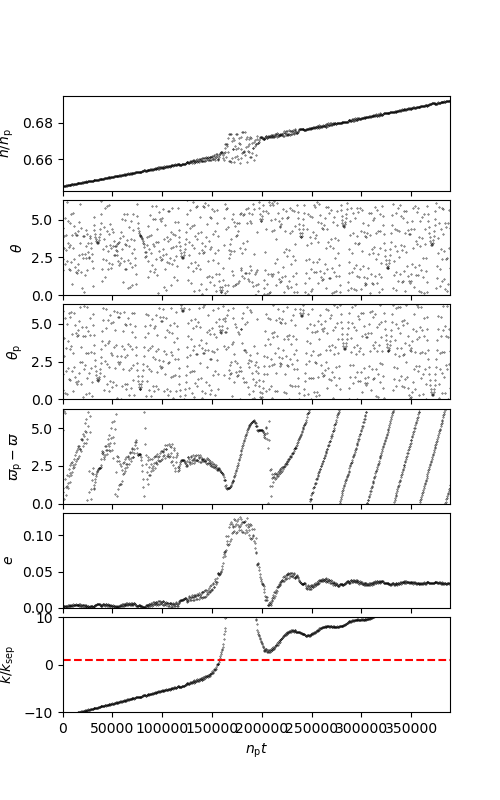

In [94]:
fig, ax= plt.subplots(6,figsize=(5,8))
#ind = 1238 # standard capture finite ep, finite Dom
#ind = 6767 # standard disrupt finite ep, finite Dom
#ind = 492 # nosec capture finite ep, finite Dom
#ind = 1694 # nosec capture small ep, small Dom
ind =  3745 # nosec disrupt finite ep, finite Dom
plot(results, jobs, ind, fig, ax, "k", results[ind].t[0], .3*results[ind].t[-1], 5e-5)
ax[5].axhline(y=1,c="r",ls="--")
ax[5].set_ylim((-10,10))

# One degree of freedom $\theta$

Throughout, I basically treat $\Gamma=\frac12\sqrt{GMa_0}e^2$ and $a_0$ is the SMA corresponding to $(j+1)n=jn_p$. There should be a slight difference in $a_0$ when things are precessing, but i don't think it impacts the dynamics beyond shifting the resonance center (i.e., its a second order effect everywhere else). Should probably incorporate it somehow into the definition of $k$.. or maybe do everything for $\omega=0$ and then shift the separatrix up in $n-\theta$ space?

I believe I have now accounted for it with the definition of $a_{\rm c}$, no?

### $H$ and $a_c$

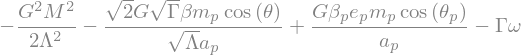

In [64]:
H

Define $a_c\longleftrightarrow n_c$ by the relation
$$
(j+1)n_c-jn_p-\omega=0
$$

Is this definition square with an apsidally precessing resonance?

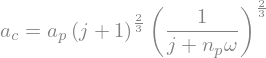

In [65]:
ac = symbols(r"a_{c}", positive=True)
display(Eq(ac, ap * ((j + 1) / (j+om*np)) ** Rational(2, 3)))

Suppose $\Lambda\simeq\sqrt{GMa_c}$ in denominator of resonant term.

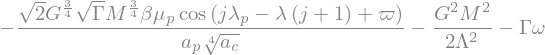

In [66]:
Hth = H.subs(
    {bp: 0, 
    th: (j + 1) * l - j * lp - pom, 
    ap * sqrt(Lam): ap * (G * M * ac)**Rational(1,4),
    mp: M*mup}
)
Hth

### Generating function 0

In [67]:
Gr, pomr = symbols(r"\Gamma_r \varpi_r")
S0 = Gr*om*t - Gr*pom
display(S0)

In [68]:
display(Eq(-pomr,S0.diff(Gr)))
display(Eq(Gam,-S0.diff(pom)))

Time dependent part of $S_r$

In [69]:
S0.diff(t)

In [70]:
solve(Eq(-pomr,S0.diff(Gr)),pom)[0]

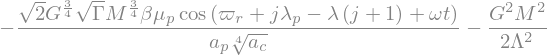

In [71]:
Hthr = Hth.subs({
    pom: solve(Eq(-pomr,S0.diff(Gr)),pom)[0]
}) + S0.diff(t).subs({Gr:solve(Eq(Gam,-S0.diff(pom)),Gr)[0] })
display(Hthr)

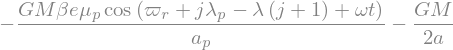

In [72]:
display(
    Hthr.subs({Gam: Rational(1, 2) * sqrt(G * M * ac) * e**2, Lam: sqrt(G * M * a)})
)

### Generating function 1

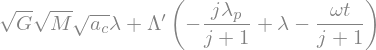

In [73]:
L1, l1 = symbols(r"\Lambda' \lambda'")
S1 = L1 * (l - j * lp / (j + 1) -om*t/(j+1)) + l * sqrt(G * M * ac)
display(S1)

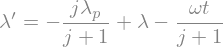

In [74]:
display(Eq(l1,S1.diff(L1)))
display(Eq(Lam,S1.diff(l)))

This way, $\Lambda'$ is small near resonance.

Time dependence of generating function $S'$.

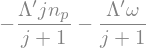

In [75]:
display(S1.diff(lp)*np + S1.diff(t))

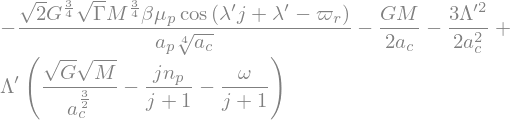

In [76]:
Hth1 = (
    Hthr.subs({l: solve(l1 - S1.diff(L1), l)[0], Lam: S1.diff(l)})
    + S1.diff(lp) * np
    + S1.diff(t)
)
Hth1 = Hth1.taylor_term(0, L1) + Hth1.taylor_term(1, L1) + Hth1.taylor_term(2, L1)
Hth1

We see the terms linear in $\Lambda'$ cancel out based on the definition of $a_{\rm c}$.

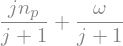

In [77]:
(np*(j+om/np)/(j+1)).expand()

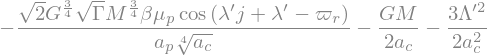

In [78]:
Hth1 = Hth1.subs(
    {sqrt(G * M) / ac ** Rational(3, 2): (np * (j + om / np) / (j + 1)).expand()}
)
Hth1

### Generating function 2

In [79]:
L2, l2, G2 = symbols(r"\Lambda'' \lambda'' \Gamma''")
S2 = G2 * ((j + 1) * l1 - pomr) + L2 * l1
display(S2)

In [80]:
display(Eq(Gam, -S2.diff(pomr)))
display(Eq(L1, S2.diff(l1)))
display(Eq(th, S2.diff(G2)))
display(Eq(l2, S2.diff(L2)))

Check $\theta$ is indeed $=\theta$ as defined at the beginning of the paper.

In [81]:
term_simplify(S2.diff(G2).subs(l1,S1.diff(L1))).subs(pomr,-S0.diff(Gr))

Success

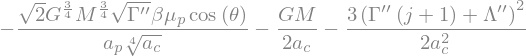

In [82]:
Hth2 = Hth1.subs(
    {
        Gam: -S2.diff(pomr),
        L1: S2.diff(l1),
        pomr: solve(th - S2.diff(G2), pomr)[0],
    }
)
Hth2

### Conserved quantity

$\Lambda''$ is a conserved quantity.

In [83]:
Eq(L2, solve(L1 - S2.diff(l1), L2)[0].collect(G2).collect(j+1))

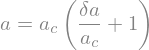

In [84]:
da = symbols(r"\delta{a}")
display(Eq(a,ac*(1+da/ac)))

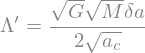

In [85]:
display(Eq(L1,Lam-sqrt(G*M*ac)))
display(Eq(L1,(sqrt(G*M*ac*(1+da/ac))-sqrt(G*M*ac)).taylor_term(1,da)))

Here we assume $\Gamma''\approx\frac12\sqrt{GMa_0}e^2$ in the definition of $\Lambda''$ and $k$... is this reasonable?

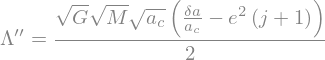

In [86]:
display(Eq(L2,
term_multiply(solve(L1 - S2.diff(l1), L2)[0].collect(G2).collect(j + 1).subs(
    {
        G2: Rational(1, 2) * sqrt(G * M * ac) * e**2,
        L1: (sqrt(G*M*ac*(1+da/ac))-sqrt(G*M*ac)).taylor_term(1,da),
    }
).collect(Rational(1,2)*sqrt(G*M*ac))
, 2/sqrt(G*M*ac))
*sqrt(G*M*ac)/2)
)

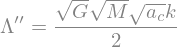

In [87]:
display(Eq(L2, Rational(1,2)*sqrt(G*M*ac)*k))

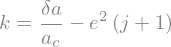

In [88]:

display(Eq(k,
term_multiply(solve(L1 - S2.diff(l1), L2)[0].collect(G2).collect(j + 1).subs(
    {
        G2: Rational(1, 2) * sqrt(G * M * ac) * e**2,
        L1: (sqrt(G*M*ac*(1+da/ac))-sqrt(G*M*ac)).taylor_term(1,da),
    }
).collect(Rational(1,2)*sqrt(G*M*ac)),1/(Rational(1,2)*sqrt(G*M*ac)))
))

### Final Hamiltonian

Separate the Hamiltonian into "radial" and resonant parts.

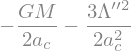

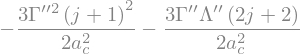

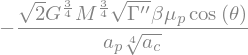

In [89]:
Hth2rad = Hth2.subs({b:0})
Hth2const = Hth2rad.taylor_term(0,G2)
Hth2res = Hth2-Hth2rad
Hth2rad = Hth2rad.taylor_term(1,G2) + Hth2rad.taylor_term(2,G2)
display(Hth2const)
display(Hth2rad)
display(Hth2res)

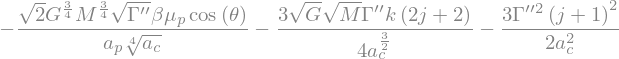

In [90]:
Hthf = (Hth2rad + Hth2res).subs(
    {
        L2: Rational(1, 2) * sqrt(G * M * ac) * k,
        #sqrt(G * M / a0): sqrt(alpha0) * np * ap,
        #k:k/sqrt(G*M)*a0**Rational(3,2)*j*np*2/(2*j+2)
    }
)
Hthf

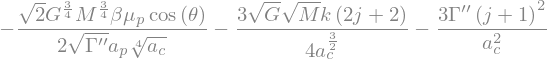

In [91]:
Hthf.diff(G2)

Now set the $\Gamma''=\frac12\sqrt{GMa_c}e^2$... Is this reasonable?

In [92]:
def term_expand(expr):
    run = 0
    for arg in expr.args:
        run += arg.expand()
    return(run)

THis expression is nicer but gives weird time units:

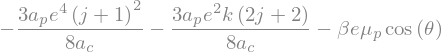

In [93]:
term_multiply(Hthf.subs({G2: Rational(1, 2)*sqrt(G*M*ac) * e**2}), 1/(G*M/ap))

In [94]:
def term_cancel(expr):
    run = 0
    for arg in expr.args:
        run += arg.cancel().factor()
    return(run)

Units of $n_p$:

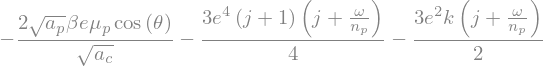

In [95]:
term_cancel(term_multiply(
    Hthf.subs({G2: Rational(1, 2) * sqrt(G * M * ac) * e**2}),
    1 / (G * M / ap / sqrt(ap / ac) / 2),
)).subs(
    {
        ap ** Rational(3, 2) / ac ** Rational(3, 2): (j+om/np)/(j+1),
    }
)

### Scaled Hamiltonian and $k_{\rm sep}$

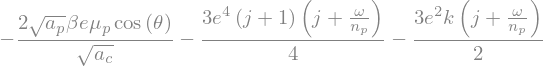

In [96]:
H_scaled0 = -(Rational(3,4)*(j+1)*(j+om/np)*e**4).collect(Rational(3,4)) - ((Rational(3,2)*(j+om/np)*k)*e**2).collect(Rational(3,2)) - 2*sqrt(ap/ac)*b*mup*e*cos(th)
H_scaled0

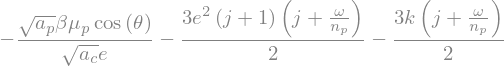

In [97]:
thdot = term_multiply(H_scaled0.diff(e),1/(2*e))
thdot

The below expression agrees with $\dot e$ in paper once you change to units of $n$ (assuming $n_p/n=\alpha^{3/2}\simeq\alpha_0^{3/2}$)

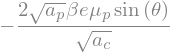

In [98]:
-H_scaled0.diff(th)

Must solve this equation to find stable values of $e$ as a function of $k$... first finding critical value of $k$

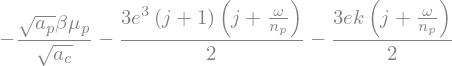

In [99]:
thdot_poly = term_multiply(thdot,e).subs(th, 0)#term_multiply(thdot, -j*e / (3 * j * (j + 1) / 2)).subs(th, 0)
display(thdot_poly)

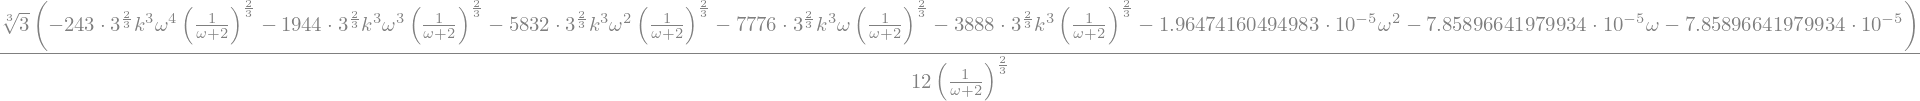

In [100]:
expr1 = (
    discriminant(thdot_poly, e)
    .subs(
        {
            j: 2,
            np: 1,
            ac: ap * ((j + 1) / (j + om)) ** Rational(2, 3),
            b: 1.8956507412695471,
        }
    )
    .subs(
        {
            ap: 1,
            mup: 5e-5,
        }
    )
)
display(expr1)

Now for the $\omega=0$ critical value. Is it worth it to solve for general $\omega$ and $\mu_{\rm p}$?

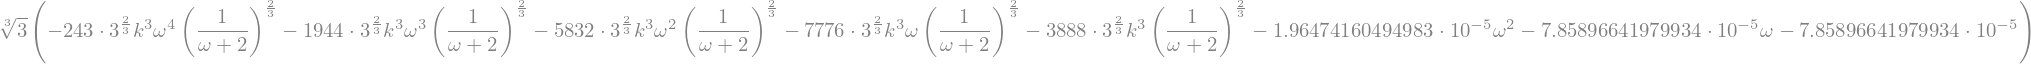

In [101]:
funcl = fraction(expr1)[0]
funcl

In [103]:
nsolve(funcl.subs({om:0}),k,1e-3)

This expression agrees with the equation in the paper when you put in $\alpha_0$

In [104]:
solve(expr1.subs(om,0),k**3)

Testing nsolve against analytic:

In [105]:
om0kcrit = (
    -solve(expr1.subs(om, 0), k**3)[0]
    .subs(
        {
            j: 2,
            np: 1,
            ac: ap * ((j + 1) / (j + om)) ** Rational(2, 3),
            b: 1.8956507412695471,
        }
    )
    .subs(
        {
            ap: 1,
            mup: 5e-5,
        }
    )
) ** (1.0 / 3)
print(om0kcrit)

0.00248932538600894


Success

### Dependence of $k_{\rm crit}$ on $\omega$

$k_{\rm crit}$ depends very weakly on $\omega$, even up to values of $0.1$ and negative values.

In [ ]:
plt.clf()
omcritvals = npy.logspace(-6, -1, 100)

kcrits = npy.zeros(len(omcritvals))
for it, omval in enumerate(omcritvals):
    kcrits[it] = nsolve(funcl.subs({om: omval}), k, 1e-3)
plt.plot(omcritvals,kcrits)

kcrits = npy.zeros(len(omcritvals))
for it, omval in enumerate(-omcritvals):
    kcrits[it] = nsolve(funcl.subs({om: omval}), k, 1e-3)

plt.plot(-omcritvals,kcrits)

plt.axhline(y=-om0kcrit)
plt.show()

### Plotting Runs with $e_{\rm p}=0$ to compare to approximate Hamiltonian

    bp: 1.5455341716765871,

In [ ]:
TMVAL = 2*npy.pi*1e6
with open("ep0_mup5e-5_tm2pi1e6_n1.6_omalpha0val3.5.pkl", "rb") as f:
    jobs, results = pickle.load(f)

In [ ]:
jobs

In [ ]:
def func(t):
    if t > 2 * npy.pi * 3e5:
        npval = npy.exp(-2 * npy.pi * 3e5 / TMVAL)
    else:
        npval = npy.exp(-t / TMVAL)
    return npval

In [ ]:
ind=0
#t1 = 2.4e5
#t2 = 2.6e5
t_ind1 = 0
t_ind2 = -1
#t_ind1 = npy.where(results[ind].t > t1)[0][0]
#t_ind2 = npy.where(results[ind].t > t2)[0][0]
tint = results[ind].t[t_ind1:t_ind2]
nint = results[ind].y[0, t_ind1:t_ind2]
npint = npy.array([func(tval) for tval in tint])
eint = results[ind].y[1, t_ind1:t_ind2]
pomint = results[ind].y[2, t_ind1:t_ind2]
thpint = results[ind].y[3, t_ind1:t_ind2]
ompint = jobs[ind][2]
omint = jobs[ind][3]
alphaint = (nint / npint) ** (2.0 / 3)
bint = 1.8956507412695471
aint = nint**(-2./3)

In [ ]:
#t1 = 2.46874e5#2.2e5
#t2 = 2.47005e5
#no_prec = [(thpint + ompint*tint - pomint) %(2*npy.pi), aint]

#t1 = 2.56917e5
#t2 = 2.57045e5
#prec = [(thpint + ompint*tint - pomint) %(2*npy.pi), aint]

In [ ]:
-1.83*5e-5**(2./3)

In [ ]:
fig, ax = plt.subplots()
#ax.scatter(prec[0], prec[1])
#ax.scatter(no_prec[0], no_prec[1])
#ax.scatter((thpint + ompint*tint - pomint) %(2*npy.pi), aint, c=tint)
ax.twinx().scatter(tint, (thpint + ompint*tint - pomint) %(2*npy.pi), c="orange",s=0.01)
#ax.scatter(tint,(thpint + ompint*tint - pomint) %(2*npy.pi),s=0.01)
kint = aint/((npint*2/3)**(-2./3))-1-3*eint**2
#daint = aint/((npint*2/3)**(-2./3))-1
ax.scatter(tint,kint,s=0.01 )#- npy.average(kint[-1000:]),s=0.01)
#ax.scatter(tint,nint/npint,s=0.01)
#ax.scatter(tint,daint,s=0.01)
#ax.scatter(tint,eint,s=0.01)
ax.axhline(y=0.0024837,c="r")
#ax.axhline(y=2/3)
#ax.twinx().scatter(tint,eint,s=0.01,c="orange")# - npy.average(daint[-1000:]),s=0.01)
#ax.scatter(tint,3*eint**2 - npy.average(3*eint[-1000:]**2),s=0.01)
#ax.set_ylim(0,2*npy.pi)
#ax.scatter(tint,results[1].y[0, t_ind1:t_ind2]-results[0].y[0, t_ind1:t_ind2],s=0.1)

In [ ]:
fig, ax = plt.subplots()
t1, t2 = npy.where(tint>23e4)[0][0], npy.where(tint>36e4)[0][0]
#ax.scatter(tint,(npint)**(-2./3))
ax.scatter((thpint + ompint*tint - pomint)[t1:t2] %(2*npy.pi), aint[t1:t2]/(npint[t1:t2])**(-2./3), c=tint[t1:t2])
#ax.scatter((thpint)[t1:t2] %(2*npy.pi), aint[t1:t2], c=tint[t1:t2])

In [ ]:
(3/2)**(2/3)

In [ ]:
jobs[1][3]/4

In [ ]:
prec-no_prec

In [ ]:
fig.show()

In [ ]:
alpha0val = (2 / 3) ** (2.0 / 3)
epvals = npy.linspace(5e-3,0.1,20)
ompvals = npy.zeros(31)
ompvals[1:] = npy.logspace(-5, -2.7865, 30)
samples = []
for i, epval in enumerate(epvals):
    for k, ompval in enumerate(ompvals):
        samples = samples + [(len(ompvals) * i + k, epval, ompval, ompval * alpha0val**3.5)]


selects =[12, 198, 384, 570,26, 212, 398, 584,5, 98, 191, 284, 377, 470, 563,19, 112, 205, 298, 391, 484, 577] + [119,105,305,291,491,477] 
jobs = []
for select in selects:
    for sampind, thetap0 in enumerate(npy.linspace(0,2*npy.pi,100,endpoint=False)):
        jobs = jobs + [(*samples[select], thetap0, sampind)]

for i in range(0,20,3):
    for k in range(5,30,7):
        ind = len(ompvals)*i+k
        print(ind, ind in selects)

In [ ]:
ls = []
for i in range(0,20,2):
    for k in range(5,30,3):
        ls = ls + [len(ompvals)*i+k]
print(ls)

In [ ]:
len(ls)